In [131]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [132]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")
csv_files = sorted(DATA_DIR.glob("m1_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No m1_*.csv files found in {DATA_DIR.resolve()}")

df = pd.concat((pd.read_csv(path) for path in csv_files), ignore_index=True)

df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")

# m1 load_factor format: size=256K/lf=0.10
parts = df["load_factor"].astype(str).str.extract(r"size=(?P<index_size>[^/]+)/lf=(?P<occupancy>[0-9.]+)")
df["index_size"] = parts["index_size"]
df["occupancy"] = pd.to_numeric(parts["occupancy"], errors="coerce")

df.head()

,timestamp,impl,op,load_factor,metric,value,unit,tag,index_size,occupancy
0,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,mean,8.088274e+07,ns,NaN,128M,0.1
1,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,median,8.088274e+07,ns,NaN,128M,0.1
2,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,std_dev,2.273422e+06,ns,NaN,128M,0.1
3,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.10,throughput_ops_per_sec,1.659411e+08,ops/s,NaN,128M,0.1
4,2026-02-27 05:32:17.273804+00:00,radix_tree,iter,size=128M/lf=0.90,mean,1.053782e+08,ns,NaN,128M,0.9


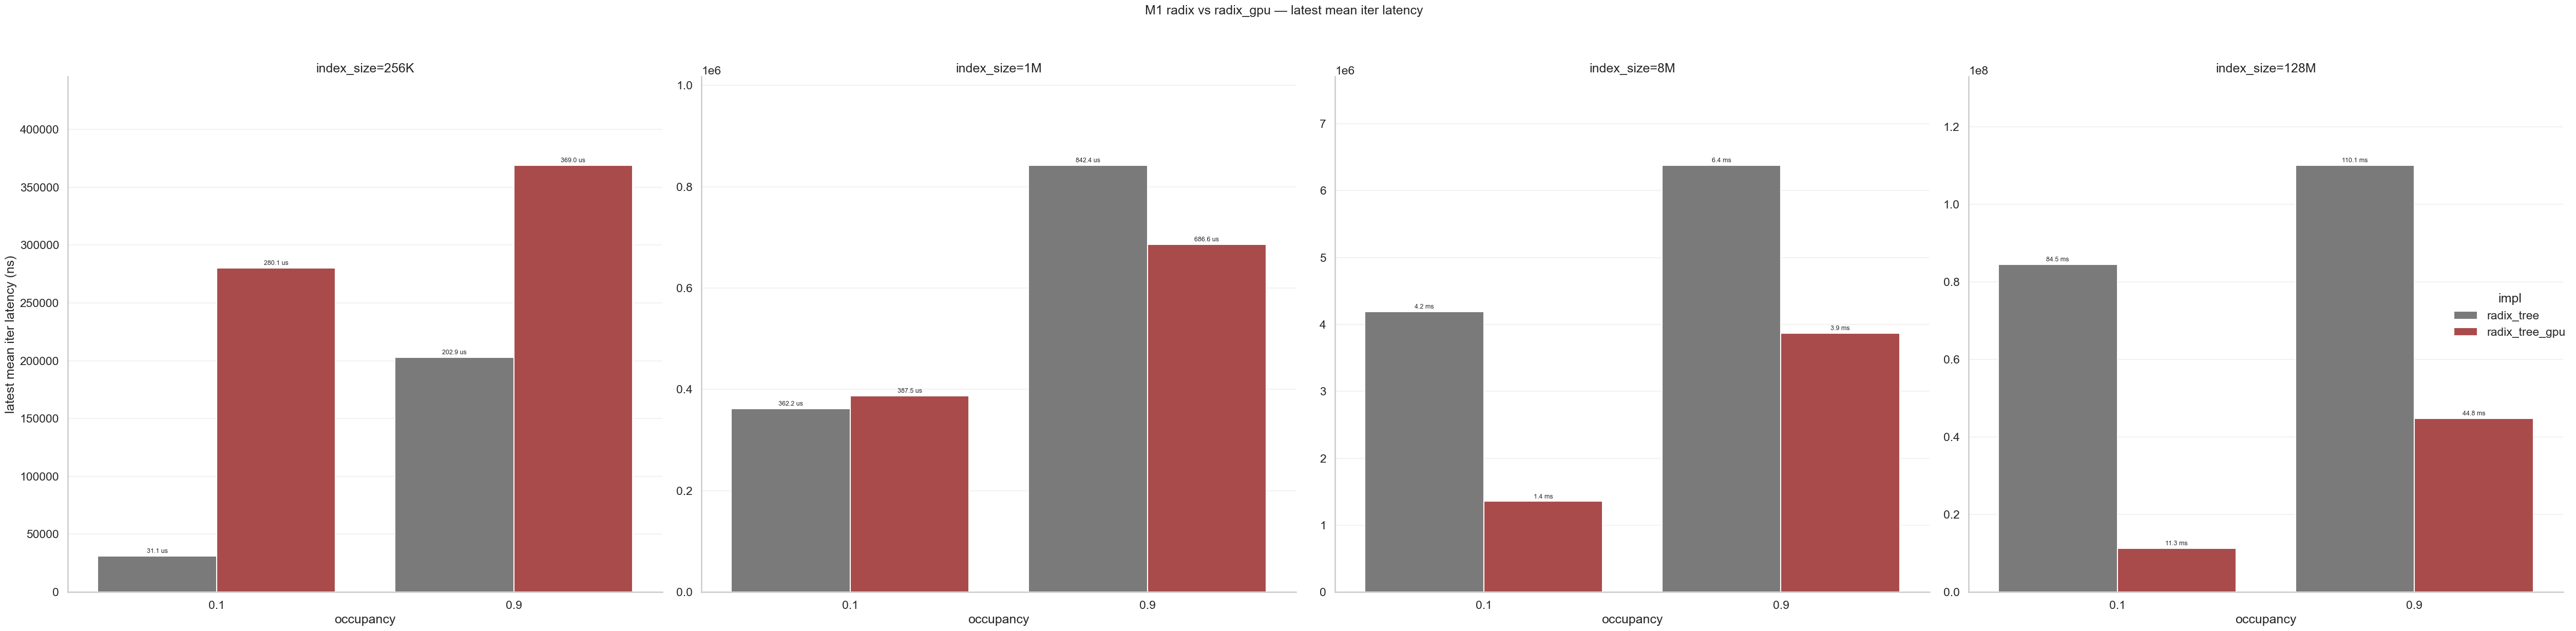

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Compare latest mean iter latency for radix vs radix_gpu.
plot_df = df[(df["op"] == "iter") & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
plot_df = plot_df[plot_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

# Focus on the occupancy levels requested for first pass.
target_occupancies = [0.10, 0.90]
plot_df = plot_df[plot_df["occupancy"].isin(target_occupancies)].copy()

if plot_df.empty:
    raise ValueError("No m1 iter mean/ns rows found for radix_tree vs radix_tree_gpu at occupancies 0.10/0.90")

# Keep only latest value per (impl, index_size, occupancy)
latest = (
    plot_df.sort_values(["timestamp", "impl", "index_size", "occupancy"]) 
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

# Stable ordering for index sizes and impl colors/labels.
size_order_hint = ["256K", "1M", "8M", "128M"]
index_sizes = [s for s in size_order_hint if s in latest["index_size"].unique()]
index_sizes += [s for s in sorted(latest["index_size"].unique()) if s not in index_sizes]

latest["index_size"] = pd.Categorical(latest["index_size"], categories=index_sizes, ordered=True)
latest["impl"] = pd.Categorical(latest["impl"], categories=["radix_tree", "radix_tree_gpu"], ordered=True)

palette = {"radix_tree": "#7a7a7a", "radix_tree_gpu": "#b93b3b"}

# One chart per index size, occupancies shown together on x-axis.
g = sns.catplot(
    data=latest.sort_values(["index_size", "occupancy", "impl"]),
    kind="bar",
    x="occupancy",
    y="value",
    hue="impl",
    col="index_size",
    sharey=False,
    height=12,
    aspect=1,
    palette=palette,
    errorbar=None,
)

g.set_titles(col_template="index_size={col_name}")
g.set_axis_labels("occupancy", "latest mean iter latency (ns)")

# Add readable labels above bars.
def human_latency(ns):
    if pd.isna(ns):
        return "-"
    ns = float(ns)
    if ns < 1_000:
        return f"{ns:.1f} ns"
    if ns < 1_000_000:
        return f"{ns/1_000:.1f} us"
    if ns < 1_000_000_000:
        return f"{ns/1_000_000:.1f} ms"
    return f"{ns/1_000_000_000:.2f} s"

for ax in g.axes.flat:
    for container in ax.containers:
        labels = [human_latency(v) if not pd.isna(v) else "" for v in container.datavalues]
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    y0, y1 = ax.get_ylim()
    ax.set_ylim(0, y1 * 1.15)
    ax.grid(True, axis="y", alpha=0.25)

plt.suptitle("M1 radix vs radix_gpu — latest mean iter latency", y=1.03, fontsize=18)
plt.tight_layout()
plt.show()

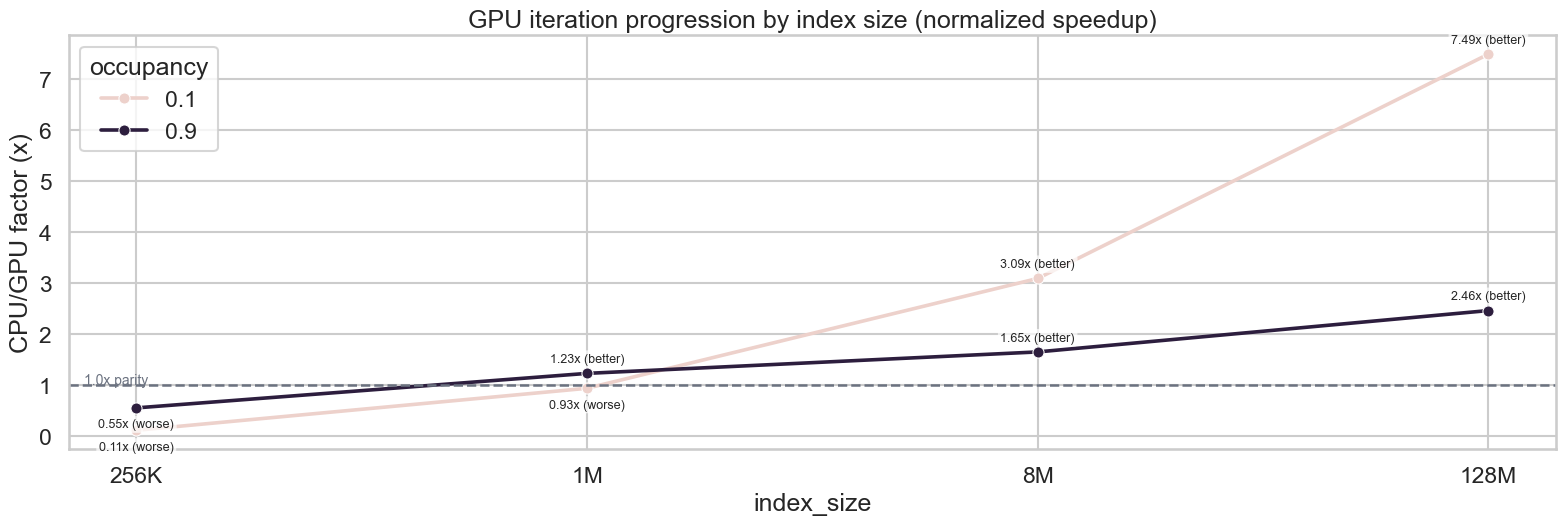

impl,index_size,occupancy,cpu_ns,gpu_ns,speedup_factor
4,256K,0.1,3.108583e+04,2.800663e+05,0.110995
2,1M,0.1,3.621963e+05,3.875311e+05,0.934625
6,8M,0.1,4.192104e+06,1.357114e+06,3.088985
0,128M,0.1,8.452774e+07,1.128654e+07,7.489255
5,256K,0.9,2.029055e+05,3.689852e+05,0.549902
3,1M,0.9,8.424004e+05,6.865560e+05,1.226994
7,8M,0.9,6.380918e+06,3.872154e+06,1.647899
1,128M,0.9,1.100886e+08,4.476274e+07,2.459380


In [134]:
# GPU progression chart (normalized): CPU time / GPU time
# >1.0 means GPU is better (faster), <1.0 means GPU is worse.

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

speed_df = df[(df["op"] == "iter") & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
speed_df = speed_df[speed_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

# Keep latest row per impl/index_size/occupancy
latest_speed = (
    speed_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

pivot = (
    latest_speed.pivot_table(
        index=["index_size", "occupancy"],
        columns="impl",
        values="value",
        aggfunc="first",
    )
    .reset_index()
)

if not {"radix_tree", "radix_tree_gpu"}.issubset(set(pivot.columns)):
    raise ValueError("Need both radix_tree and radix_tree_gpu latest values to compute speedup")

pivot["speedup_factor"] = pivot["radix_tree"] / pivot["radix_tree_gpu"]

size_order = ["256K", "1M", "8M", "128M"]
present_sizes = [s for s in size_order if s in pivot["index_size"].unique()]
pivot["index_size"] = pd.Categorical(pivot["index_size"], categories=present_sizes, ordered=True)
pivot = pivot.sort_values(["occupancy", "index_size"])

# Optional first-pass focus on occupancies used earlier
target_occupancies = [0.10, 0.90]
pivot = pivot[pivot["occupancy"].isin(target_occupancies)]

plt.figure(figsize=(16, 5.6))
ax = sns.lineplot(
    data=pivot,
    x="index_size",
    y="speedup_factor",
    hue="occupancy",
    marker="o",
    linewidth=2.6,
    markersize=8,
)

ax.axhline(1.0, linestyle="--", linewidth=1.8, color="#6b7280")
ax.text(0.01, 1.01, "1.0x parity", transform=ax.get_yaxis_transform(), color="#6b7280", fontsize=10)

for _, row in pivot.iterrows():
    f = float(row["speedup_factor"])
    label = f"{f:.2f}x ({'better' if f >= 1.0 else 'worse'})"
    yoff = 8 if f >= 1.0 else -14
    ax.annotate(
        label,
        xy=(row["index_size"], f),
        xytext=(0, yoff),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )

ax.set_title("GPU iteration progression by index size (normalized speedup)")
ax.set_xlabel("index_size")
ax.set_ylabel("CPU/GPU factor (x)")
ax.legend(title="occupancy", loc="best", frameon=True)

plt.tight_layout()
plt.show()

display(
    pivot[["index_size", "occupancy", "radix_tree", "radix_tree_gpu", "speedup_factor"]]
    .rename(columns={
        "radix_tree": "cpu_ns",
        "radix_tree_gpu": "gpu_ns",
    })
)

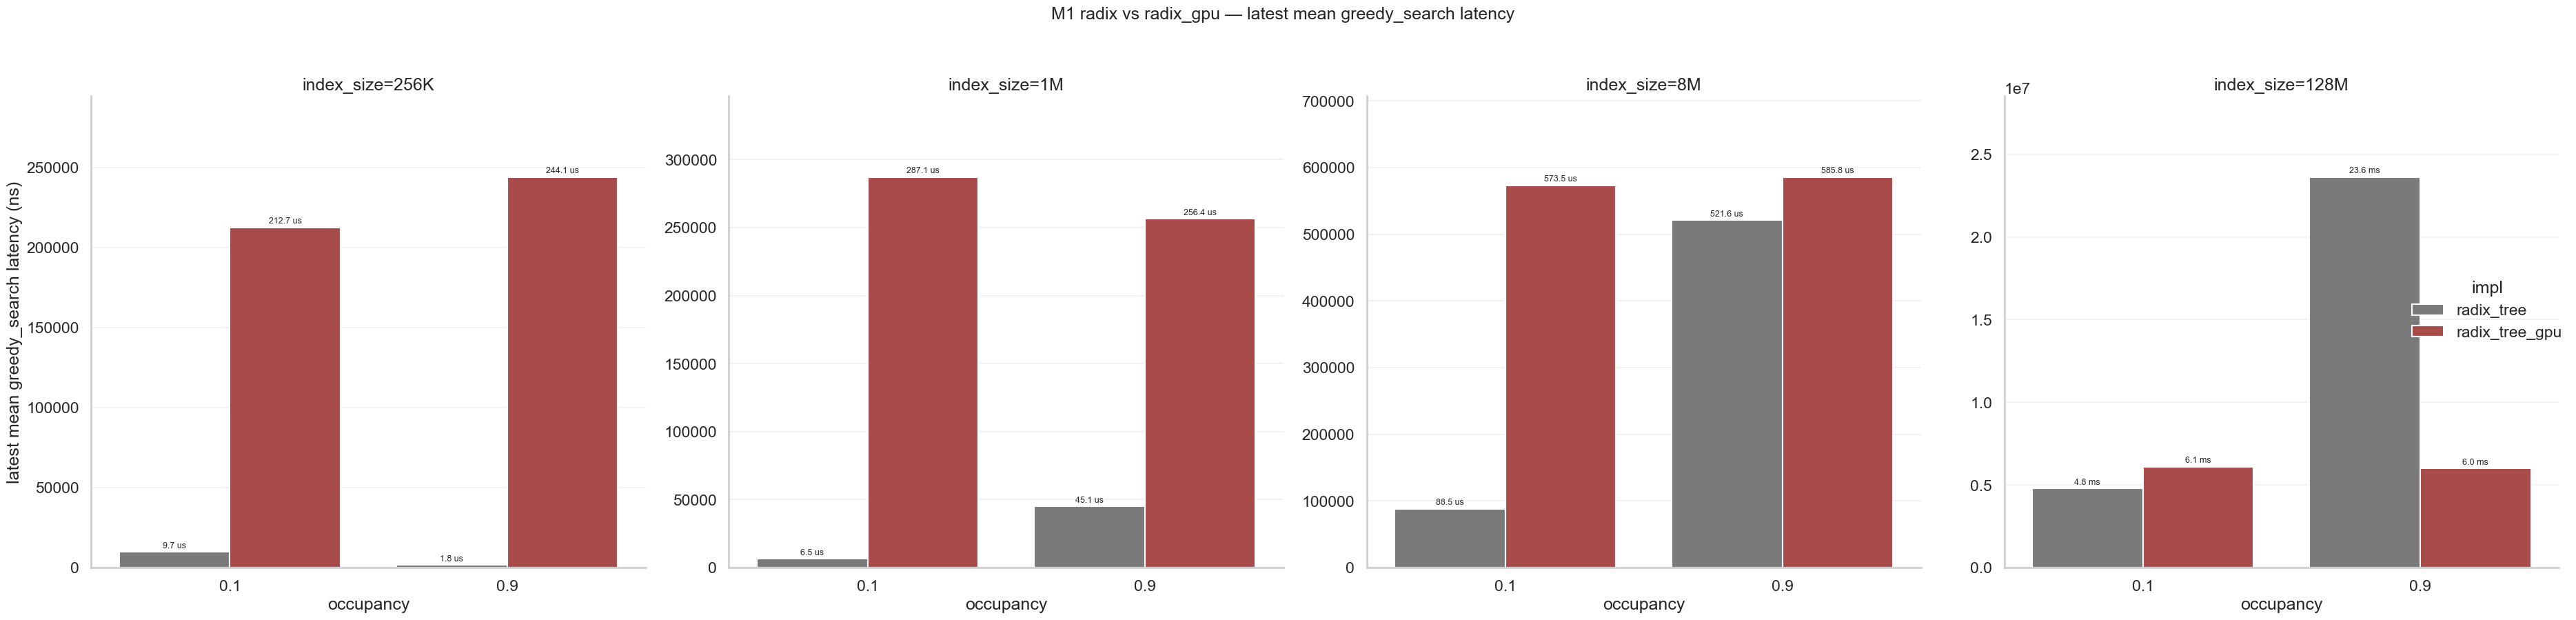

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Compare latest mean greedy_search latency for radix vs radix_gpu.
# Note: CSV op name is `contains_greedy`.
op_name = "contains_greedy"
display_name = "greedy_search"

plot_df = df[(df["op"] == op_name) & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
plot_df = plot_df[plot_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

target_occupancies = [0.10, 0.90]
plot_df = plot_df[plot_df["occupancy"].isin(target_occupancies)].copy()

if plot_df.empty:
    raise ValueError(f"No m1 {op_name} mean/ns rows found for radix_tree vs radix_tree_gpu at occupancies 0.10/0.90")

latest = (
    plot_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

size_order_hint = ["256K", "1M", "8M", "128M"]
index_sizes = [s for s in size_order_hint if s in latest["index_size"].unique()]
index_sizes += [s for s in sorted(latest["index_size"].unique()) if s not in index_sizes]

latest["index_size"] = pd.Categorical(latest["index_size"], categories=index_sizes, ordered=True)
latest["impl"] = pd.Categorical(latest["impl"], categories=["radix_tree", "radix_tree_gpu"], ordered=True)

palette = {"radix_tree": "#7a7a7a", "radix_tree_gpu": "#b93b3b"}

g = sns.catplot(
    data=latest.sort_values(["index_size", "occupancy", "impl"]),
    kind="bar",
    x="occupancy",
    y="value",
    hue="impl",
    col="index_size",
    sharey=False,
    height=8.8,
    aspect=1,
    palette=palette,
    errorbar=None,
)

g.set_titles(col_template="index_size={col_name}")
g.set_axis_labels("occupancy", f"latest mean {display_name} latency (ns)")

def human_latency(ns):
    if pd.isna(ns):
        return "-"
    ns = float(ns)
    if ns < 1_000:
        return f"{ns:.1f} ns"
    if ns < 1_000_000:
        return f"{ns/1_000:.1f} us"
    if ns < 1_000_000_000:
        return f"{ns/1_000_000:.1f} ms"
    return f"{ns/1_000_000_000:.2f} s"

for ax in g.axes.flat:
    for container in ax.containers:
        labels = [human_latency(v) if not pd.isna(v) else "" for v in container.datavalues]
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    y0, y1 = ax.get_ylim()
    ax.set_ylim(0, y1 * 1.15)
    ax.grid(True, axis="y", alpha=0.25)

plt.suptitle(f"M1 radix vs radix_gpu — latest mean {display_name} latency", y=1.03, fontsize=18)
plt.tight_layout()
plt.show()

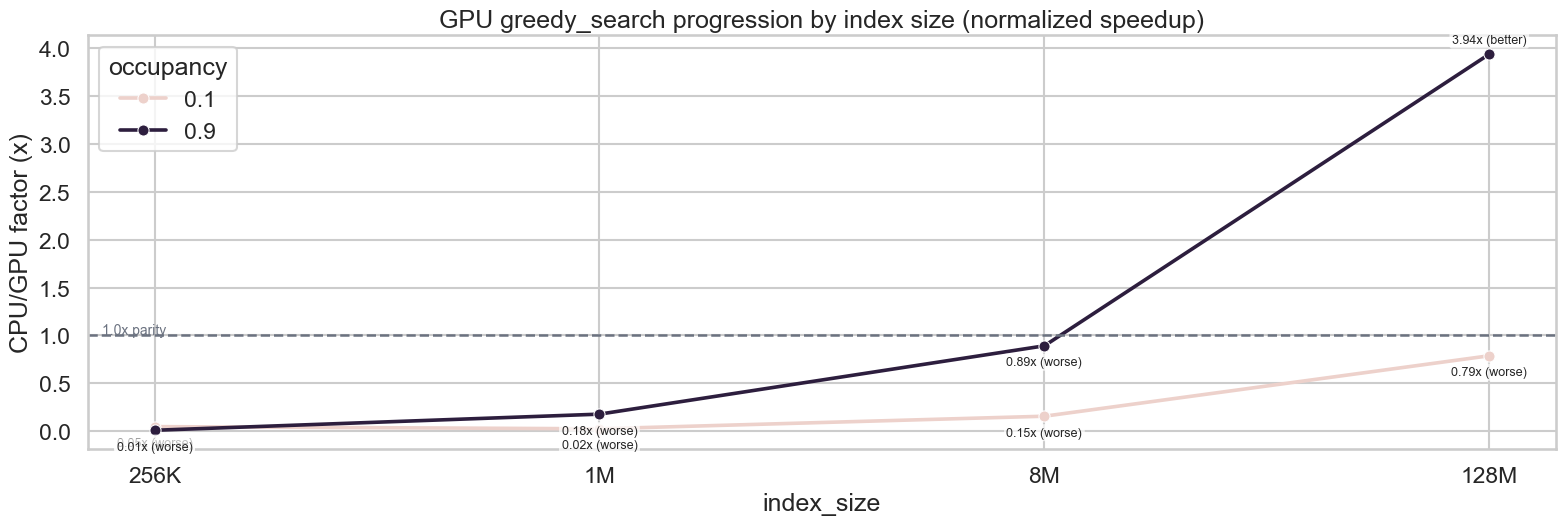

impl,index_size,occupancy,cpu_ns,gpu_ns,speedup_factor
4,256K,0.1,9.733433e+03,2.126936e+05,0.045763
2,1M,0.1,6.545558e+03,2.870636e+05,0.022802
6,8M,0.1,8.851245e+04,5.734647e+05,0.154347
0,128M,0.1,4.798318e+06,6.101760e+06,0.786382
5,256K,0.9,1.801418e+03,2.440512e+05,0.007381
3,1M,0.9,4.511542e+04,2.563617e+05,0.175984
7,8M,0.9,5.215570e+05,5.857917e+05,0.890345
1,128M,0.9,2.361734e+07,5.994466e+06,3.939857


In [136]:
# GPU progression chart (normalized) for greedy_search: CPU time / GPU time
# >1.0 means GPU is better (faster), <1.0 means GPU is worse.

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

op_name = "contains_greedy"
display_name = "greedy_search"

speed_df = df[(df["op"] == op_name) & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
speed_df = speed_df[speed_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

latest_speed = (
    speed_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

pivot = (
    latest_speed.pivot_table(
        index=["index_size", "occupancy"],
        columns="impl",
        values="value",
        aggfunc="first",
    )
    .reset_index()
)

if not {"radix_tree", "radix_tree_gpu"}.issubset(set(pivot.columns)):
    raise ValueError("Need both radix_tree and radix_tree_gpu latest values to compute speedup")

pivot["speedup_factor"] = pivot["radix_tree"] / pivot["radix_tree_gpu"]

size_order = ["256K", "1M", "8M", "128M"]
present_sizes = [s for s in size_order if s in pivot["index_size"].unique()]
pivot["index_size"] = pd.Categorical(pivot["index_size"], categories=present_sizes, ordered=True)
pivot = pivot.sort_values(["occupancy", "index_size"])

target_occupancies = [0.10, 0.90]
pivot = pivot[pivot["occupancy"].isin(target_occupancies)]

plt.figure(figsize=(16, 5.6))
ax = sns.lineplot(
    data=pivot,
    x="index_size",
    y="speedup_factor",
    hue="occupancy",
    marker="o",
    linewidth=2.6,
    markersize=8,
)

ax.axhline(1.0, linestyle="--", linewidth=1.8, color="#6b7280")
ax.text(0.01, 1.01, "1.0x parity", transform=ax.get_yaxis_transform(), color="#6b7280", fontsize=10)

for _, row in pivot.iterrows():
    f = float(row["speedup_factor"])
    label = f"{f:.2f}x ({'better' if f >= 1.0 else 'worse'})"
    yoff = 8 if f >= 1.0 else -14
    ax.annotate(
        label,
        xy=(row["index_size"], f),
        xytext=(0, yoff),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )

ax.set_title(f"GPU {display_name} progression by index size (normalized speedup)")
ax.set_xlabel("index_size")
ax.set_ylabel("CPU/GPU factor (x)")
ax.legend(title="occupancy", loc="best", frameon=True)

plt.tight_layout()
plt.show()

display(
    pivot[["index_size", "occupancy", "radix_tree", "radix_tree_gpu", "speedup_factor"]]
    .rename(columns={
        "radix_tree": "cpu_ns",
        "radix_tree_gpu": "gpu_ns",
    })
)

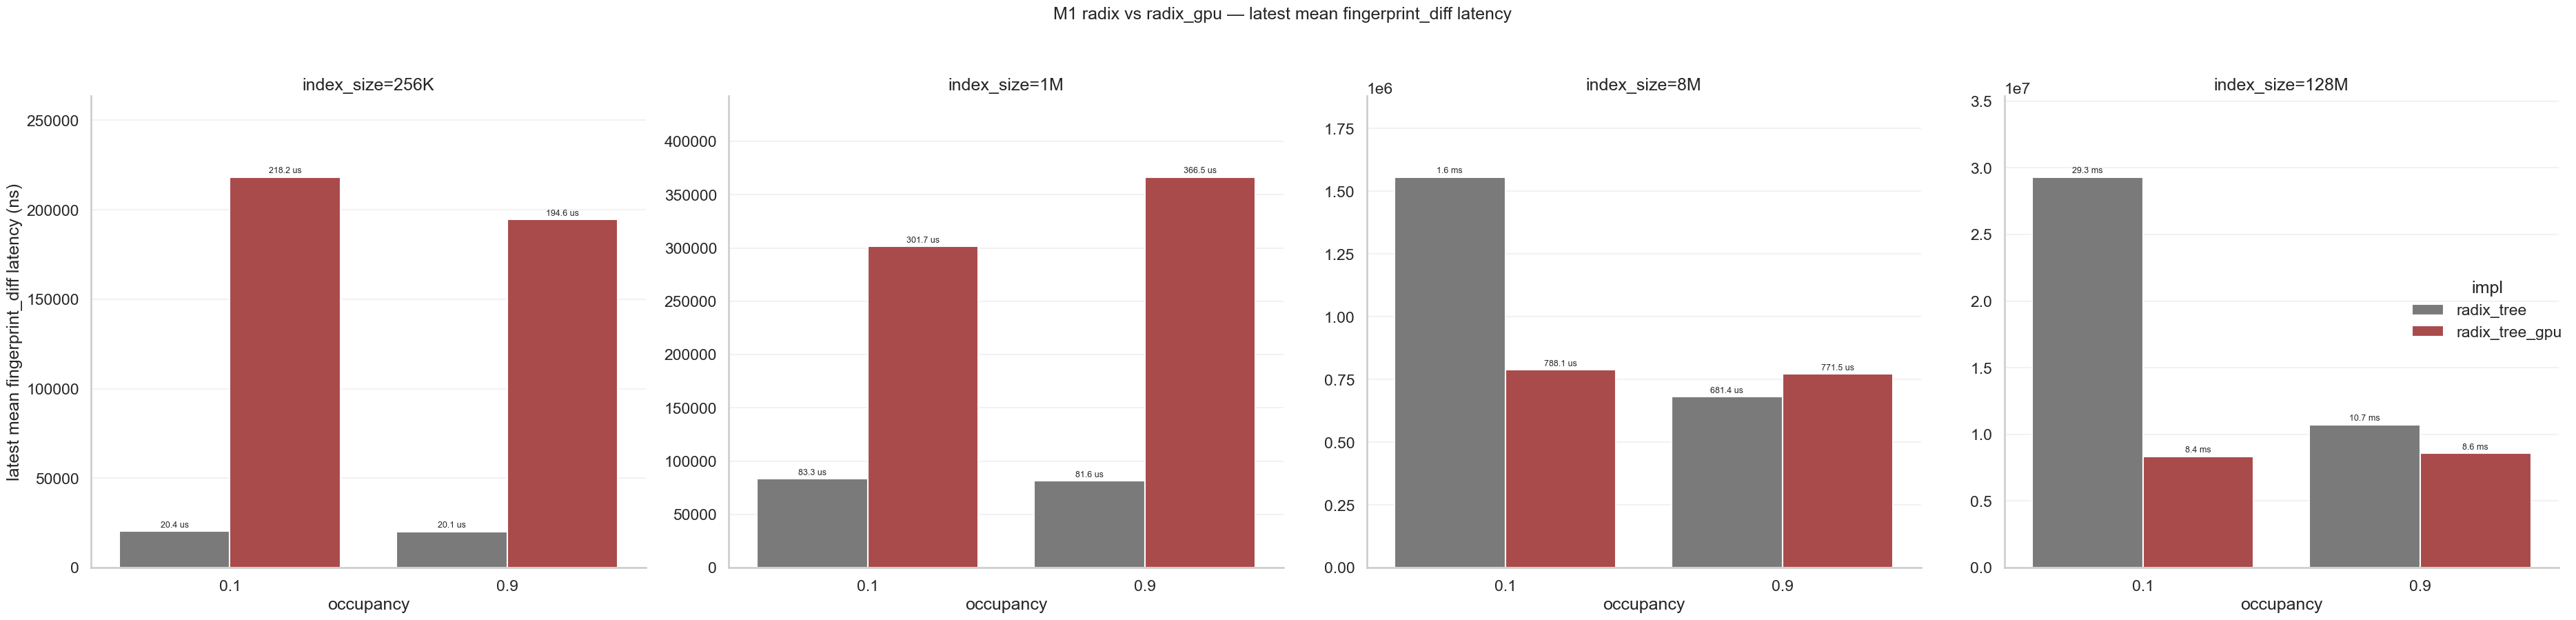

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Compare latest mean fingerprint_diff latency for radix vs radix_gpu.
op_name = "fingerprint_diff"
display_name = "fingerprint_diff"

plot_df = df[(df["op"] == op_name) & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
plot_df = plot_df[plot_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

target_occupancies = [0.10, 0.90]
plot_df = plot_df[plot_df["occupancy"].isin(target_occupancies)].copy()

if plot_df.empty:
    raise ValueError(f"No m1 {op_name} mean/ns rows found for radix_tree vs radix_tree_gpu at occupancies 0.10/0.90")

latest = (
    plot_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

size_order_hint = ["256K", "1M", "8M", "128M"]
index_sizes = [s for s in size_order_hint if s in latest["index_size"].unique()]
index_sizes += [s for s in sorted(latest["index_size"].unique()) if s not in index_sizes]

latest["index_size"] = pd.Categorical(latest["index_size"], categories=index_sizes, ordered=True)
latest["impl"] = pd.Categorical(latest["impl"], categories=["radix_tree", "radix_tree_gpu"], ordered=True)

palette = {"radix_tree": "#7a7a7a", "radix_tree_gpu": "#b93b3b"}

g = sns.catplot(
    data=latest.sort_values(["index_size", "occupancy", "impl"]),
    kind="bar",
    x="occupancy",
    y="value",
    hue="impl",
    col="index_size",
    sharey=False,
    height=8.8,
    aspect=1,
    palette=palette,
    errorbar=None,
)

g.set_titles(col_template="index_size={col_name}")
g.set_axis_labels("occupancy", f"latest mean {display_name} latency (ns)")

def human_latency(ns):
    if pd.isna(ns):
        return "-"
    ns = float(ns)
    if ns < 1_000:
        return f"{ns:.1f} ns"
    if ns < 1_000_000:
        return f"{ns/1_000:.1f} us"
    if ns < 1_000_000_000:
        return f"{ns/1_000_000:.1f} ms"
    return f"{ns/1_000_000_000:.2f} s"

for ax in g.axes.flat:
    for container in ax.containers:
        labels = [human_latency(v) if not pd.isna(v) else "" for v in container.datavalues]
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    y0, y1 = ax.get_ylim()
    ax.set_ylim(0, y1 * 1.15)
    ax.grid(True, axis="y", alpha=0.25)

plt.suptitle(f"M1 radix vs radix_gpu — latest mean {display_name} latency", y=1.03, fontsize=18)
plt.tight_layout()
plt.show()

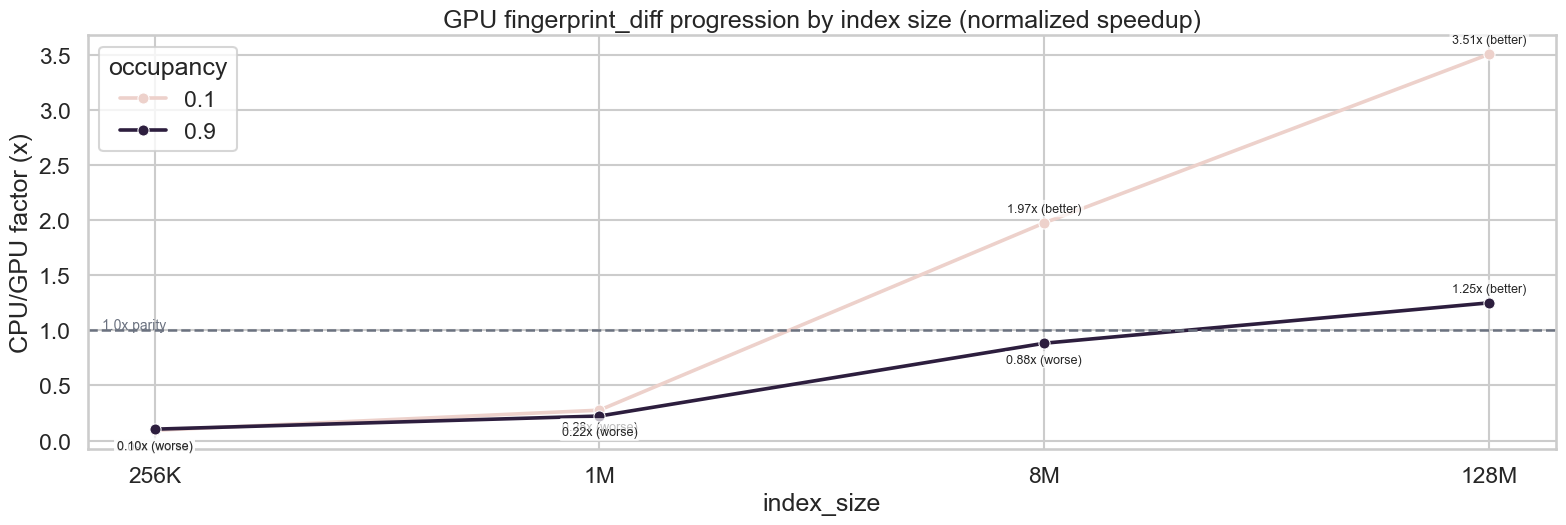

impl,index_size,occupancy,cpu_ns,gpu_ns,speedup_factor
4,256K,0.1,2.042257e+04,2.182240e+05,0.093585
2,1M,0.1,8.325380e+04,3.017332e+05,0.275919
6,8M,0.1,1.556311e+06,7.881006e+05,1.974762
0,128M,0.1,2.930505e+07,8.360690e+06,3.505100
5,256K,0.9,2.014853e+04,1.945962e+05,0.103540
3,1M,0.9,8.160445e+04,3.664957e+05,0.222661
7,8M,0.9,6.814220e+05,7.714606e+05,0.883288
1,128M,0.9,1.074010e+07,8.594349e+06,1.249670


In [138]:
# GPU progression chart (normalized) for fingerprint_diff: CPU time / GPU time
# >1.0 means GPU is better (faster), <1.0 means GPU is worse.

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

op_name = "fingerprint_diff"
display_name = "fingerprint_diff"

speed_df = df[(df["op"] == op_name) & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
speed_df = speed_df[speed_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

latest_speed = (
    speed_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

pivot = (
    latest_speed.pivot_table(
        index=["index_size", "occupancy"],
        columns="impl",
        values="value",
        aggfunc="first",
    )
    .reset_index()
)

if not {"radix_tree", "radix_tree_gpu"}.issubset(set(pivot.columns)):
    raise ValueError("Need both radix_tree and radix_tree_gpu latest values to compute speedup")

pivot["speedup_factor"] = pivot["radix_tree"] / pivot["radix_tree_gpu"]

size_order = ["256K", "1M", "8M", "128M"]
present_sizes = [s for s in size_order if s in pivot["index_size"].unique()]
pivot["index_size"] = pd.Categorical(pivot["index_size"], categories=present_sizes, ordered=True)
pivot = pivot.sort_values(["occupancy", "index_size"])

target_occupancies = [0.10, 0.90]
pivot = pivot[pivot["occupancy"].isin(target_occupancies)]

plt.figure(figsize=(16, 5.6))
ax = sns.lineplot(
    data=pivot,
    x="index_size",
    y="speedup_factor",
    hue="occupancy",
    marker="o",
    linewidth=2.6,
    markersize=8,
)

ax.axhline(1.0, linestyle="--", linewidth=1.8, color="#6b7280")
ax.text(0.01, 1.01, "1.0x parity", transform=ax.get_yaxis_transform(), color="#6b7280", fontsize=10)

for _, row in pivot.iterrows():
    f = float(row["speedup_factor"])
    label = f"{f:.2f}x ({'better' if f >= 1.0 else 'worse'})"
    yoff = 8 if f >= 1.0 else -14
    ax.annotate(
        label,
        xy=(row["index_size"], f),
        xytext=(0, yoff),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )

ax.set_title(f"GPU {display_name} progression by index size (normalized speedup)")
ax.set_xlabel("index_size")
ax.set_ylabel("CPU/GPU factor (x)")
ax.legend(title="occupancy", loc="best", frameon=True)

plt.tight_layout()
plt.show()

display(
    pivot[["index_size", "occupancy", "radix_tree", "radix_tree_gpu", "speedup_factor"]]
    .rename(columns={
        "radix_tree": "cpu_ns",
        "radix_tree_gpu": "gpu_ns",
    })
)

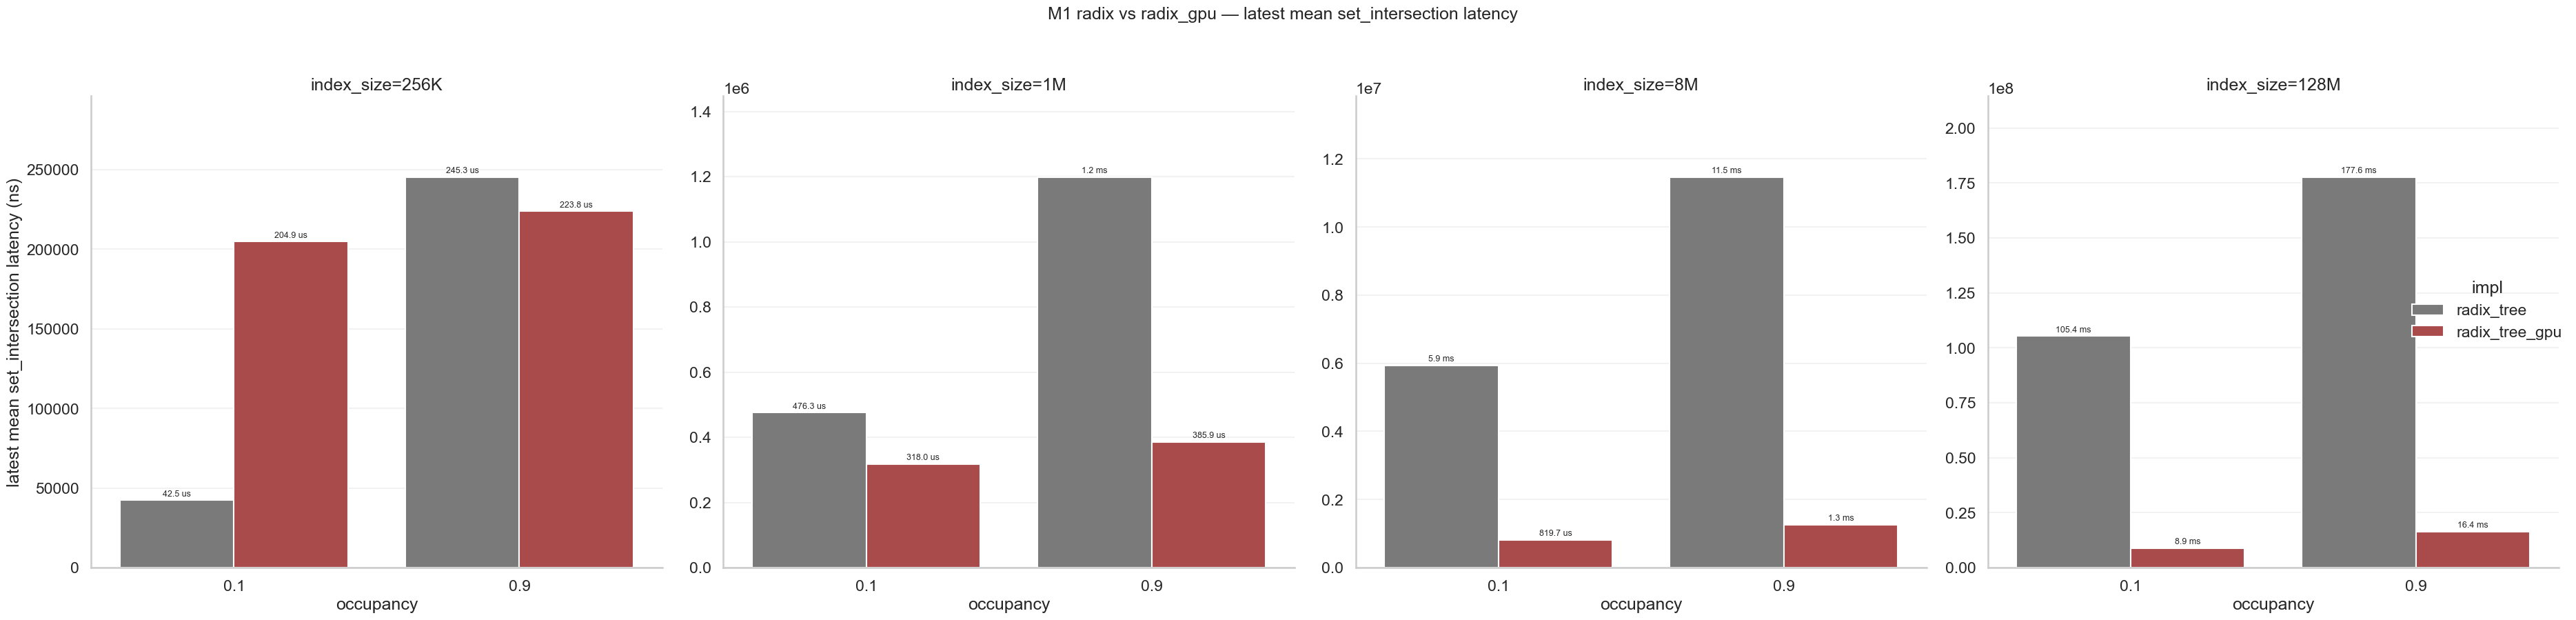

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Compare latest mean set_intersection latency for radix vs radix_gpu.
op_name = "set_intersection"
display_name = "set_intersection"

plot_df = df[(df["op"] == op_name) & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
plot_df = plot_df[plot_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

target_occupancies = [0.10, 0.90]
plot_df = plot_df[plot_df["occupancy"].isin(target_occupancies)].copy()

if plot_df.empty:
    raise ValueError(f"No m1 {op_name} mean/ns rows found for radix_tree vs radix_tree_gpu at occupancies 0.10/0.90")

latest = (
    plot_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

size_order_hint = ["256K", "1M", "8M", "128M"]
index_sizes = [s for s in size_order_hint if s in latest["index_size"].unique()]
index_sizes += [s for s in sorted(latest["index_size"].unique()) if s not in index_sizes]

latest["index_size"] = pd.Categorical(latest["index_size"], categories=index_sizes, ordered=True)
latest["impl"] = pd.Categorical(latest["impl"], categories=["radix_tree", "radix_tree_gpu"], ordered=True)

palette = {"radix_tree": "#7a7a7a", "radix_tree_gpu": "#b93b3b"}

g = sns.catplot(
    data=latest.sort_values(["index_size", "occupancy", "impl"]),
    kind="bar",
    x="occupancy",
    y="value",
    hue="impl",
    col="index_size",
    sharey=False,
    height=8.8,
    aspect=1,
    palette=palette,
    errorbar=None,
)

g.set_titles(col_template="index_size={col_name}")
g.set_axis_labels("occupancy", f"latest mean {display_name} latency (ns)")

def human_latency(ns):
    if pd.isna(ns):
        return "-"
    ns = float(ns)
    if ns < 1_000:
        return f"{ns:.1f} ns"
    if ns < 1_000_000:
        return f"{ns/1_000:.1f} us"
    if ns < 1_000_000_000:
        return f"{ns/1_000_000:.1f} ms"
    return f"{ns/1_000_000_000:.2f} s"

for ax in g.axes.flat:
    for container in ax.containers:
        labels = [human_latency(v) if not pd.isna(v) else "" for v in container.datavalues]
        ax.bar_label(container, labels=labels, padding=2, fontsize=9)

    y0, y1 = ax.get_ylim()
    ax.set_ylim(0, y1 * 1.15)
    ax.grid(True, axis="y", alpha=0.25)

plt.suptitle(f"M1 radix vs radix_gpu — latest mean {display_name} latency", y=1.03, fontsize=18)
plt.tight_layout()
plt.show()

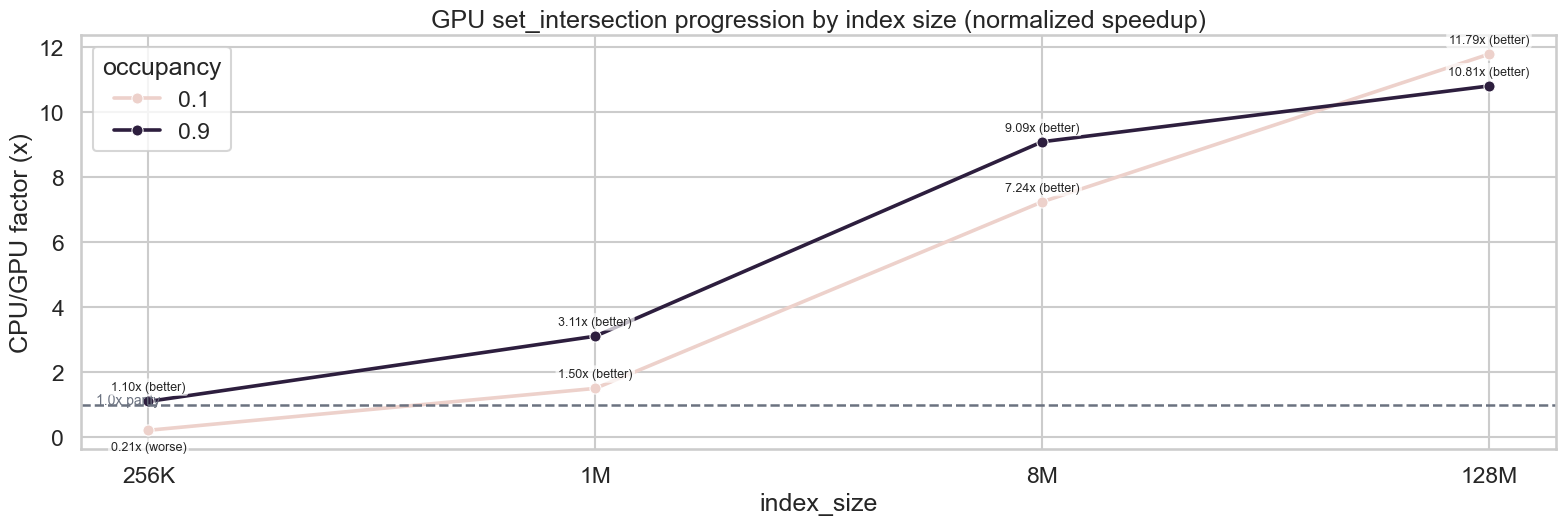

impl,index_size,occupancy,cpu_ns,gpu_ns,speedup_factor
4,256K,0.1,4.253943e+04,2.048715e+05,0.207640
2,1M,0.1,4.762868e+05,3.179657e+05,1.497919
6,8M,0.1,5.937210e+06,8.196624e+05,7.243481
0,128M,0.1,1.053630e+08,8.934279e+06,11.793117
5,256K,0.9,2.453254e+05,2.238495e+05,1.095939
3,1M,0.9,1.198396e+06,3.858784e+05,3.105632
7,8M,0.9,1.146306e+07,1.260484e+06,9.094171
1,128M,0.9,1.776317e+08,1.642753e+07,10.813054


In [140]:
# GPU progression chart (normalized) for set_intersection: CPU time / GPU time
# >1.0 means GPU is better (faster), <1.0 means GPU is worse.

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

op_name = "set_intersection"
display_name = "set_intersection"

speed_df = df[(df["op"] == op_name) & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
speed_df = speed_df[speed_df["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

latest_speed = (
    speed_df.sort_values(["timestamp", "impl", "index_size", "occupancy"])
    .drop_duplicates(["impl", "index_size", "occupancy"], keep="last")
)

pivot = (
    latest_speed.pivot_table(
        index=["index_size", "occupancy"],
        columns="impl",
        values="value",
        aggfunc="first",
    )
    .reset_index()
)

if not {"radix_tree", "radix_tree_gpu"}.issubset(set(pivot.columns)):
    raise ValueError("Need both radix_tree and radix_tree_gpu latest values to compute speedup")

pivot["speedup_factor"] = pivot["radix_tree"] / pivot["radix_tree_gpu"]

size_order = ["256K", "1M", "8M", "128M"]
present_sizes = [s for s in size_order if s in pivot["index_size"].unique()]
pivot["index_size"] = pd.Categorical(pivot["index_size"], categories=present_sizes, ordered=True)
pivot = pivot.sort_values(["occupancy", "index_size"])

target_occupancies = [0.10, 0.90]
pivot = pivot[pivot["occupancy"].isin(target_occupancies)]

plt.figure(figsize=(16, 5.6))
ax = sns.lineplot(
    data=pivot,
    x="index_size",
    y="speedup_factor",
    hue="occupancy",
    marker="o",
    linewidth=2.6,
    markersize=8,
)

ax.axhline(1.0, linestyle="--", linewidth=1.8, color="#6b7280")
ax.text(0.01, 1.01, "1.0x parity", transform=ax.get_yaxis_transform(), color="#6b7280", fontsize=10)

for _, row in pivot.iterrows():
    f = float(row["speedup_factor"])
    label = f"{f:.2f}x ({'better' if f >= 1.0 else 'worse'})"
    yoff = 8 if f >= 1.0 else -14
    ax.annotate(
        label,
        xy=(row["index_size"], f),
        xytext=(0, yoff),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )

ax.set_title(f"GPU {display_name} progression by index size (normalized speedup)")
ax.set_xlabel("index_size")
ax.set_ylabel("CPU/GPU factor (x)")
ax.legend(title="occupancy", loc="best", frameon=True)

plt.tight_layout()
plt.show()

display(
    pivot[["index_size", "occupancy", "radix_tree", "radix_tree_gpu", "speedup_factor"]]
    .rename(columns={
        "radix_tree": "cpu_ns",
        "radix_tree_gpu": "gpu_ns",
    })
)

In [141]:
# set_predicate prep: parse dimensions and assign predicate families
import pandas as pd

sp = df[(df["op"] == "set_predicate") & (df["metric"] == "mean") & (df["unit"] == "ns")].copy()
sp = sp[sp["impl"].isin(["radix_tree", "radix_tree_gpu"])].copy()

parts = sp["load_factor"].astype(str).str.extract(
    r"size=(?P<index_size>[^/]+)/lf=(?P<occupancy>[0-9.]+)/overlap=(?P<overlap>[0-9.]+)/pred=(?P<predicate>[^/]+)"
)
sp["index_size"] = parts["index_size"]
sp["occupancy"] = pd.to_numeric(parts["occupancy"], errors="coerce")
sp["overlap"] = pd.to_numeric(parts["overlap"], errors="coerce")
sp["predicate"] = parts["predicate"]

family_map = {
    "intersect_2": "family_2",
    "diff_ab": "family_2",
    "sym_diff": "family_2",
    "consensus_3": "family_3",
    "unique_a": "family_3",
}
sp["family"] = sp["predicate"].map(family_map)

# Keep latest datapoint for each benchmark key.
sp_latest = (
    sp.sort_values(["timestamp", "impl", "index_size", "occupancy", "overlap", "predicate"])
    .drop_duplicates(["impl", "index_size", "occupancy", "overlap", "predicate"], keep="last")
)

size_order = ["256K", "1M", "8M", "128M"]
overlap_order = [0.10, 0.50, 0.90]
occupancy_order = [0.10, 0.90]
pred_order = ["intersect_2", "diff_ab", "sym_diff", "consensus_3", "unique_a"]

sp_latest["index_size"] = pd.Categorical(sp_latest["index_size"], categories=size_order, ordered=True)
sp_latest["overlap"] = pd.Categorical(sp_latest["overlap"], categories=overlap_order, ordered=True)
sp_latest["occupancy"] = pd.Categorical(sp_latest["occupancy"], categories=occupancy_order, ordered=True)
sp_latest["predicate"] = pd.Categorical(sp_latest["predicate"], categories=pred_order, ordered=True)


def human_latency(ns):
    if pd.isna(ns):
        return "-"
    ns = float(ns)
    if ns < 1_000:
        return f"{ns:.1f} ns"
    if ns < 1_000_000:
        return f"{ns/1_000:.1f} us"
    if ns < 1_000_000_000:
        return f"{ns/1_000_000:.1f} ms"
    return f"{ns/1_000_000_000:.2f} s"

sp_latest.head()

,timestamp,impl,op,load_factor,metric,value,unit,tag,index_size,occupancy,overlap,predicate,family
280,2026-02-27 07:54:34.971746+00:00,radix_tree,set_predicate,size=128M/lf=0.10/overlap=0.10/pred=consensus_3,mean,2.368188e+08,ns,NaN,128M,0.1,0.1,consensus_3,family_3
284,2026-02-27 07:54:34.971746+00:00,radix_tree,set_predicate,size=128M/lf=0.10/overlap=0.10/pred=diff_ab,mean,2.019771e+08,ns,NaN,128M,0.1,0.1,diff_ab,family_2
288,2026-02-27 07:54:34.971746+00:00,radix_tree,set_predicate,size=128M/lf=0.10/overlap=0.10/pred=intersect_2,mean,1.152020e+08,ns,NaN,128M,0.1,0.1,intersect_2,family_2
292,2026-02-27 07:54:34.971746+00:00,radix_tree,set_predicate,size=128M/lf=0.10/overlap=0.10/pred=sym_diff,mean,2.870255e+08,ns,NaN,128M,0.1,0.1,sym_diff,family_2
296,2026-02-27 07:54:34.971746+00:00,radix_tree,set_predicate,size=128M/lf=0.10/overlap=0.10/pred=unique_a,mean,3.410335e+08,ns,NaN,128M,0.1,0.1,unique_a,family_3


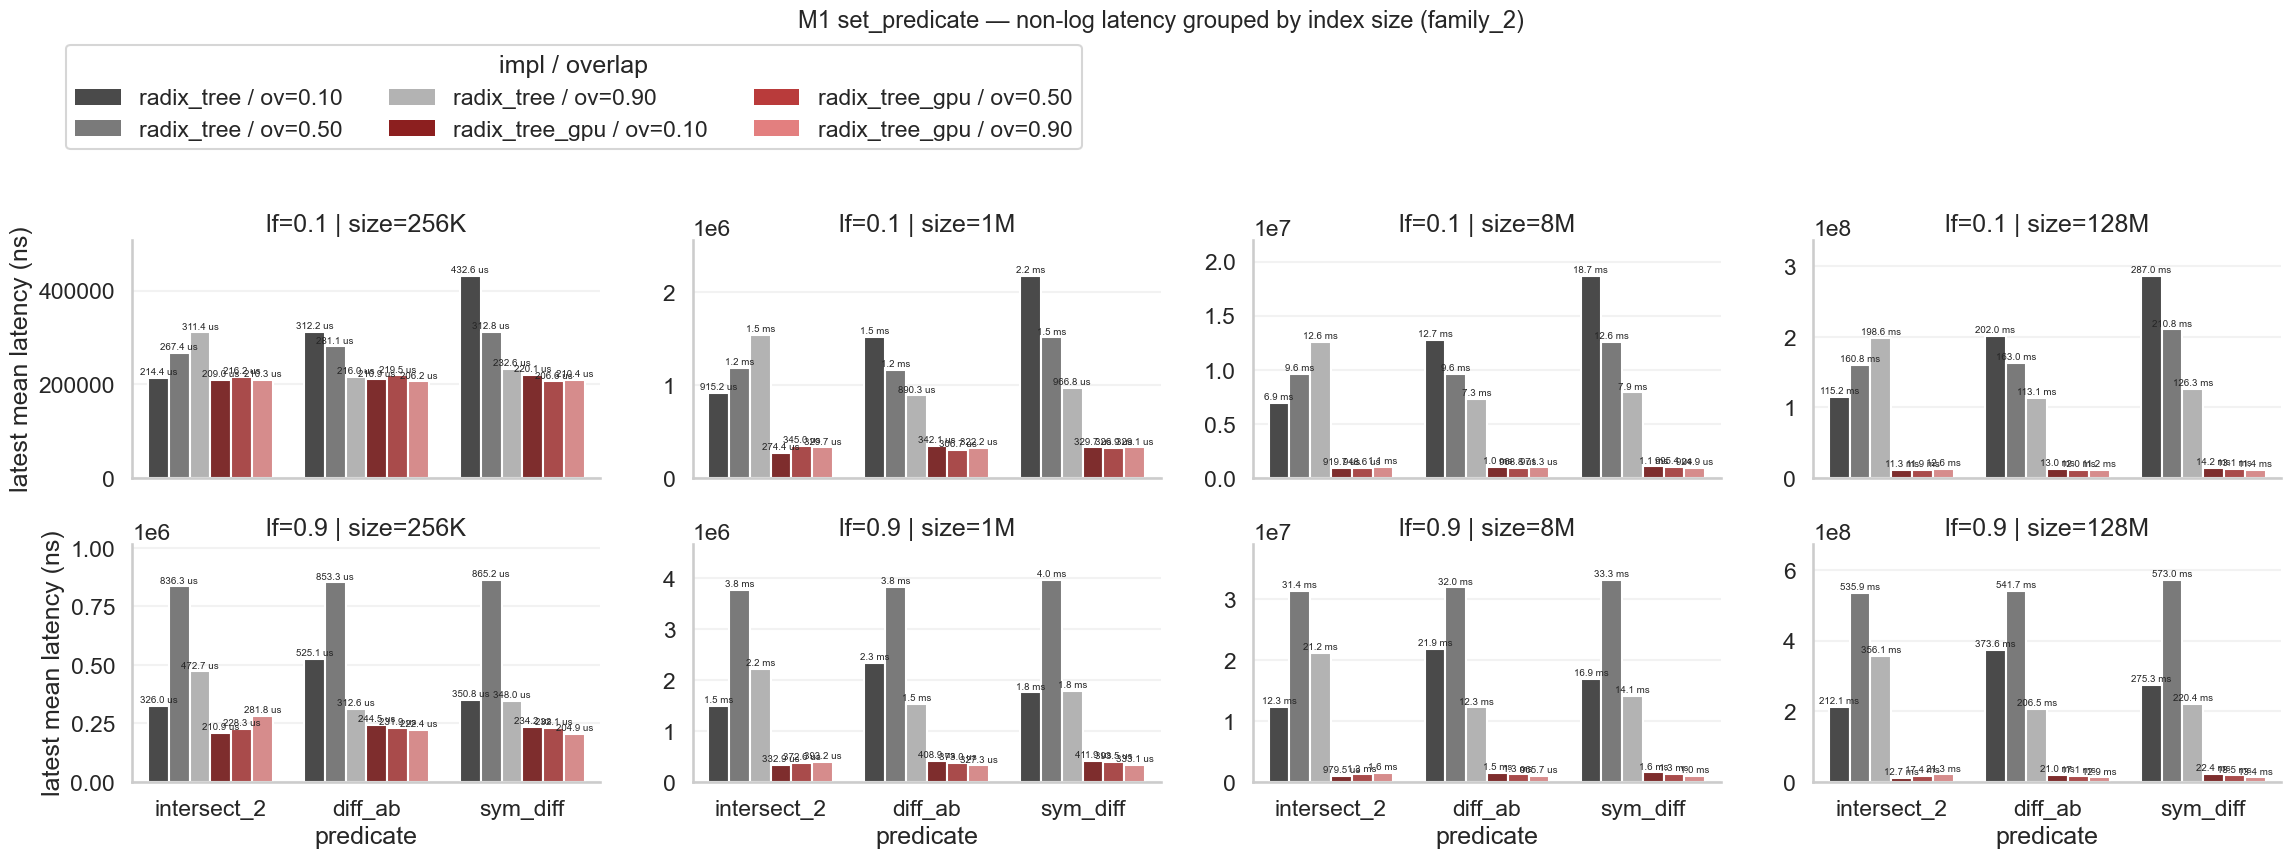

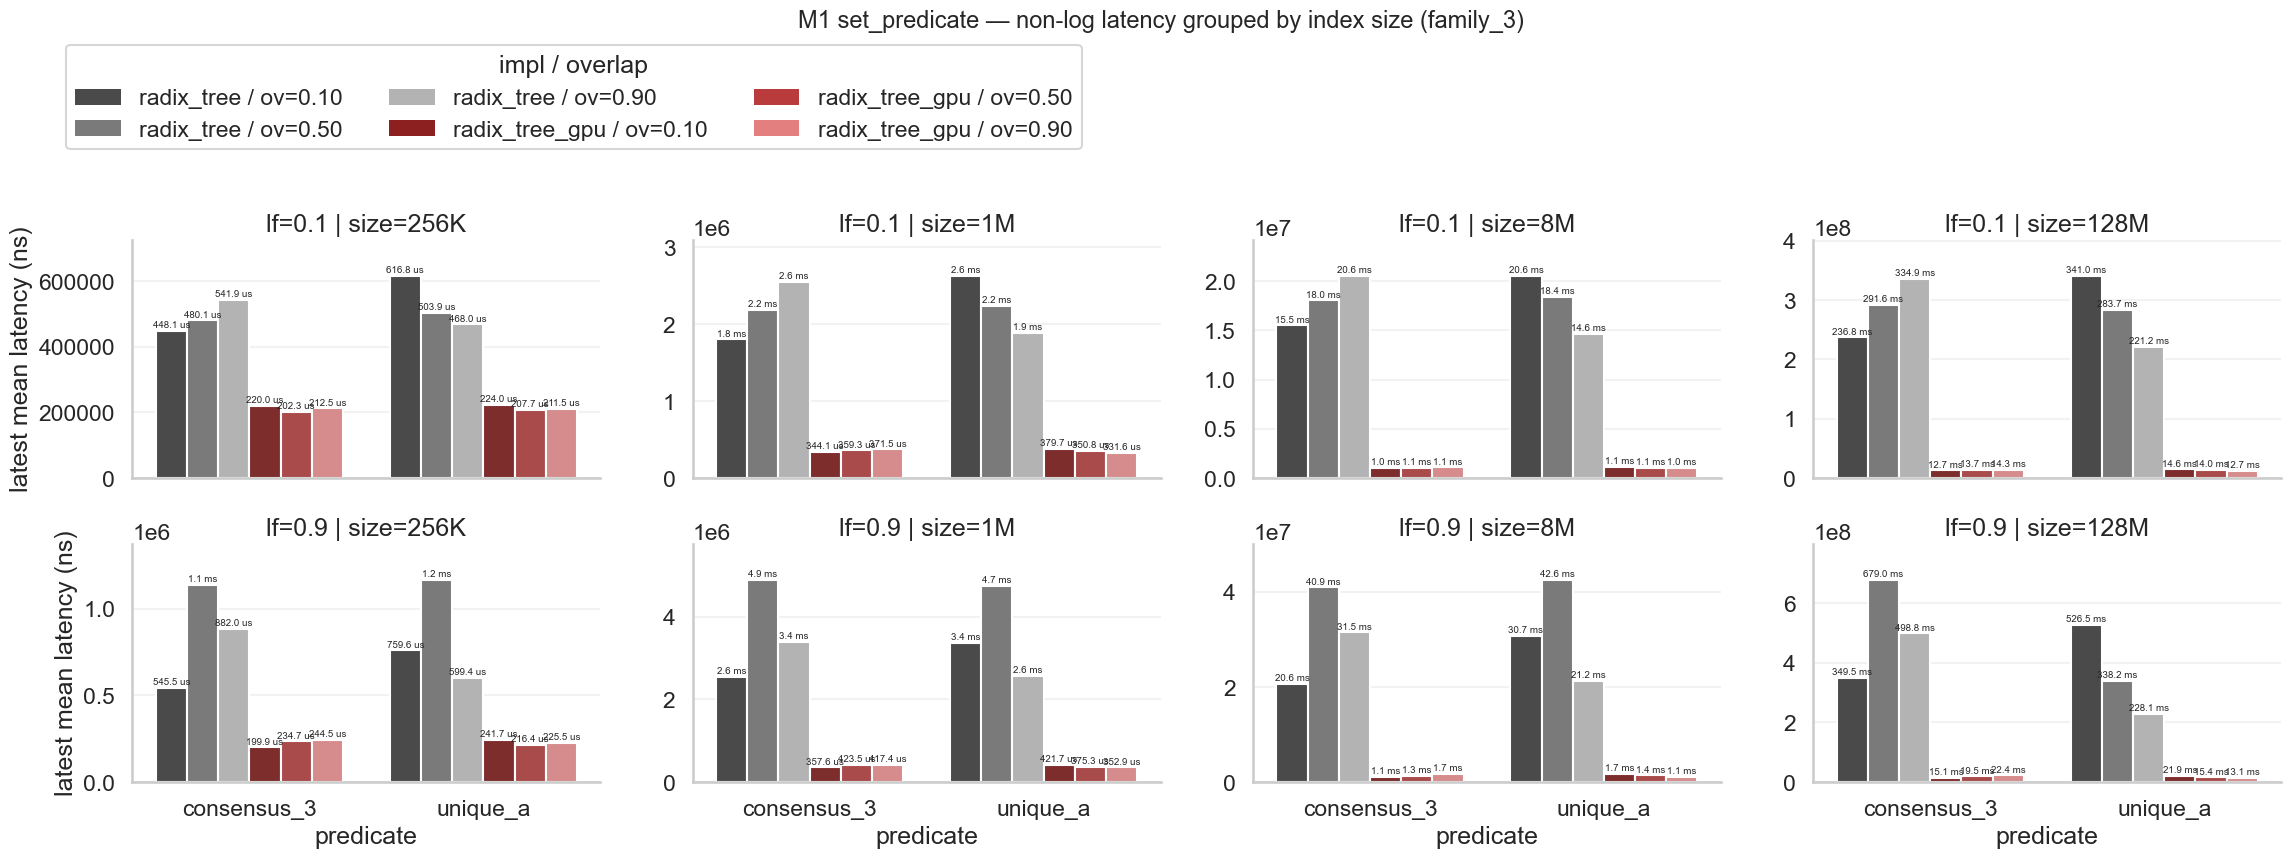

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

sns.set_theme(style="whitegrid", context="talk")

for family, fam_preds in [
    ("family_2", ["intersect_2", "diff_ab", "sym_diff"]),
    ("family_3", ["consensus_3", "unique_a"]),
]:
    fam = sp_latest[sp_latest["family"] == family].copy()
    fam["predicate"] = fam["predicate"].astype(str)
    fam = fam[fam["predicate"].isin(fam_preds)]
    if fam.empty:
        continue

    fam["predicate"] = pd.Categorical(fam["predicate"], categories=fam_preds, ordered=True)
    fam["index_size"] = pd.Categorical(fam["index_size"], categories=size_order, ordered=True)
    fam["occupancy"] = pd.Categorical(fam["occupancy"], categories=occupancy_order, ordered=True)
    fam["overlap"] = pd.Categorical(fam["overlap"], categories=overlap_order, ordered=True)

    # Group charts by index size; show all predicates on x-axis.
    # Include both impl and overlap as separate series so each index-size chart contains all readings.
    fam["series"] = fam["impl"].astype(str) + " / ov=" + fam["overlap"].astype(float).map(lambda x: f"{x:.2f}")
    series_order = [
        f"{impl} / ov={ov:.2f}"
        for impl in ["radix_tree", "radix_tree_gpu"]
        for ov in overlap_order
    ]

    # Color design: grayscale shades for CPU overlaps, blue shades for GPU overlaps.
    cpu_overlap_colors = {0.10: "#4a4a4a", 0.50: "#7a7a7a", 0.90: "#b3b3b3"}
    gpu_overlap_colors = {0.10: "#8c1f1f", 0.50: "#b93b3b", 0.90: "#e37f7f"}
    series_palette = {
        f"radix_tree / ov={ov:.2f}": cpu_overlap_colors[float(ov)]
        for ov in overlap_order
    }
    series_palette.update(
        {
            f"radix_tree_gpu / ov={ov:.2f}": gpu_overlap_colors[float(ov)]
            for ov in overlap_order
        }
    )

    g = sns.catplot(
        data=fam.sort_values(["occupancy", "index_size", "predicate", "overlap", "impl"]),
        kind="bar",
        x="predicate",
        y="value",
        hue="series",
        hue_order=series_order,
        palette=series_palette,
        row="occupancy",
        row_order=occupancy_order,
        col="index_size",
        col_order=size_order,
        errorbar=None,
        sharey=False,
        height=4.35,
        aspect=1.12,
    )

    g.set_titles(row_template="lf={row_name}", col_template="size={col_name}")
    g.set_axis_labels("predicate", "latest mean latency (ns)")

    for ax in g.axes.flat:
        for container in ax.containers:
            labels = [human_latency(v) if not pd.isna(v) else "" for v in container.datavalues]
            ax.bar_label(container, labels=labels, padding=1, fontsize=7)
        y0, y1 = ax.get_ylim()
        ax.set_ylim(0, y1 * 1.12)
        ax.grid(True, axis="y", alpha=0.25)

    # Place a single clean legend in the figure top-left with enough headroom.
    if g._legend is not None:
        g._legend.remove()
    legend_handles = [Patch(facecolor=series_palette[s], edgecolor="none", label=s) for s in series_order]
    g.figure.legend(
        handles=legend_handles,
        labels=series_order,
        title="impl / overlap",
        loc="upper left",
        bbox_to_anchor=(0.015, 0.97),
        ncol=3,
        frameon=True,
        borderaxespad=0.6,
    )

    plt.suptitle(
        f"M1 set_predicate — non-log latency grouped by index size ({family})",
        y=0.995,
        fontsize=17,
    )
    # Reserve extra space under title/legend so top-left plot never overlaps.
    g.figure.subplots_adjust(top=0.73, left=0.05, right=0.99)
    plt.show()

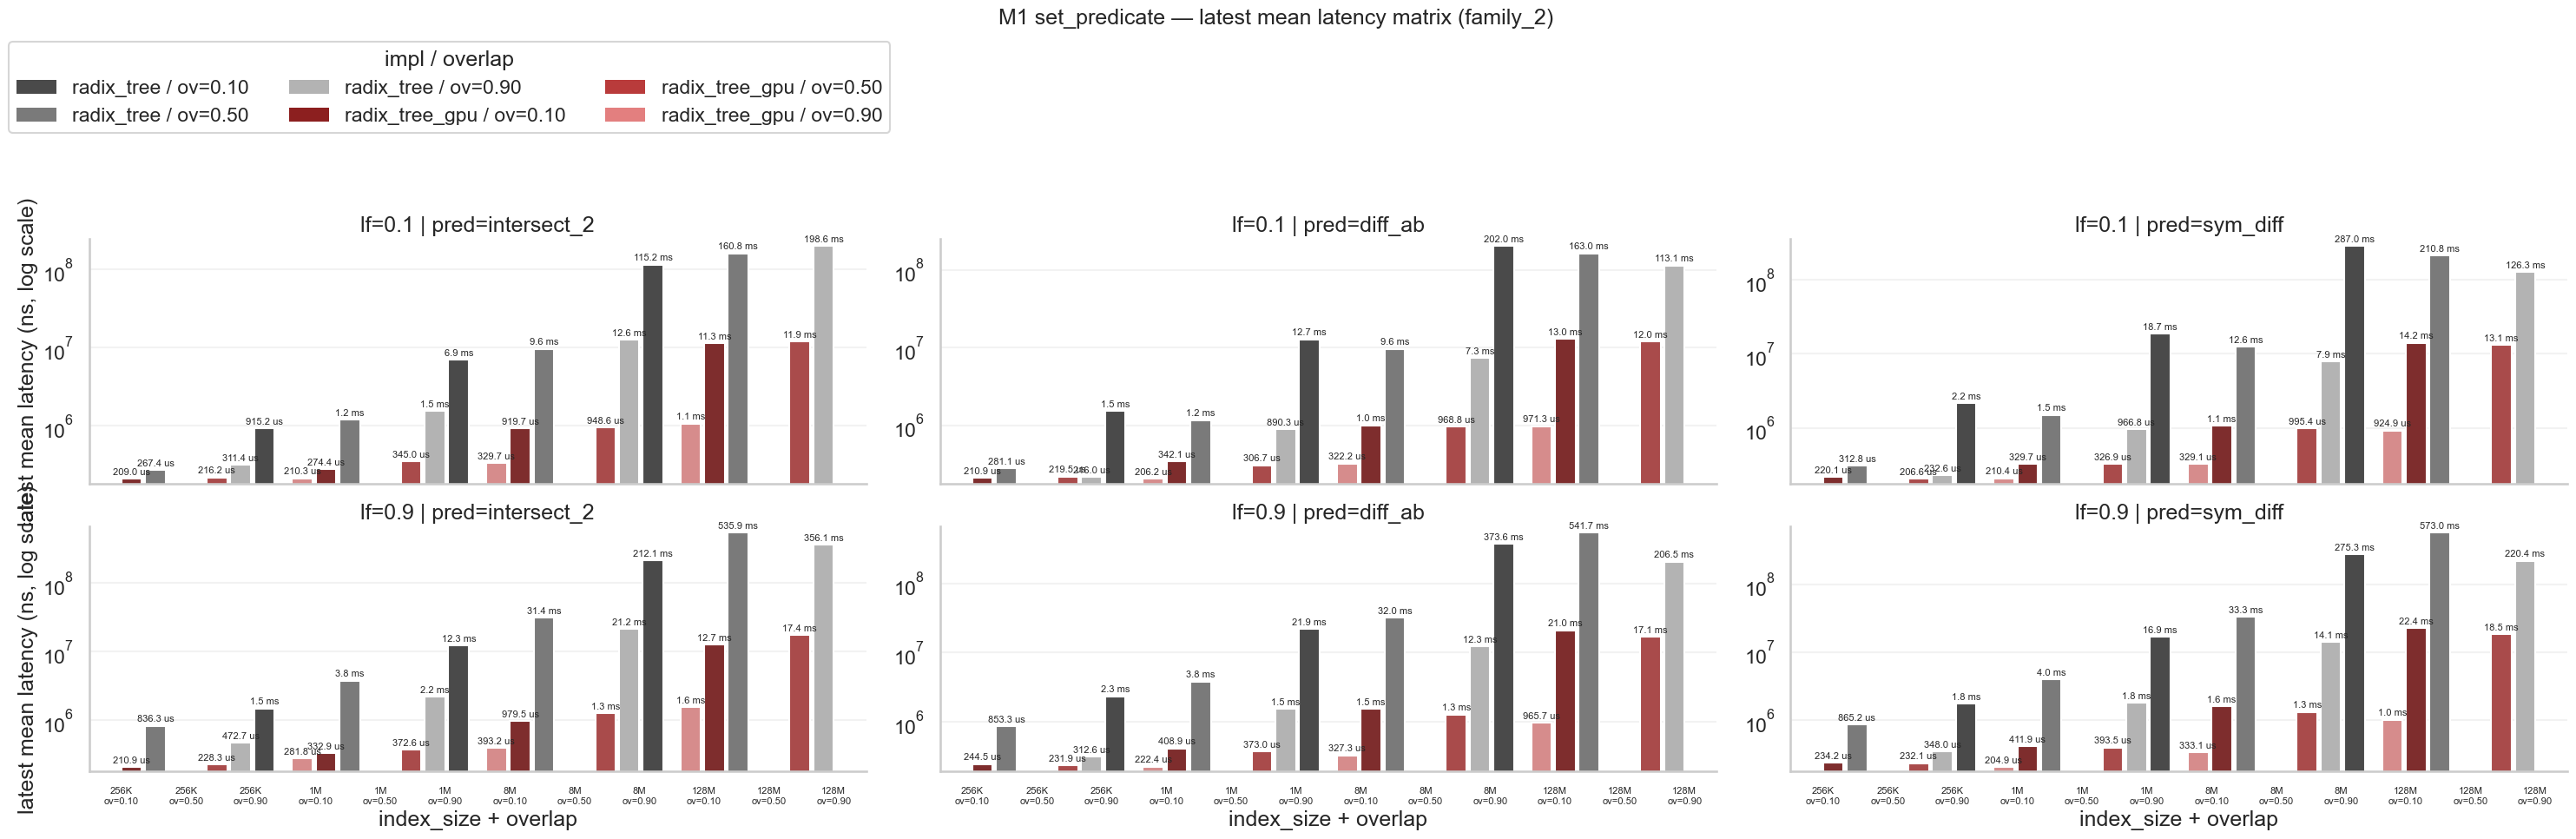

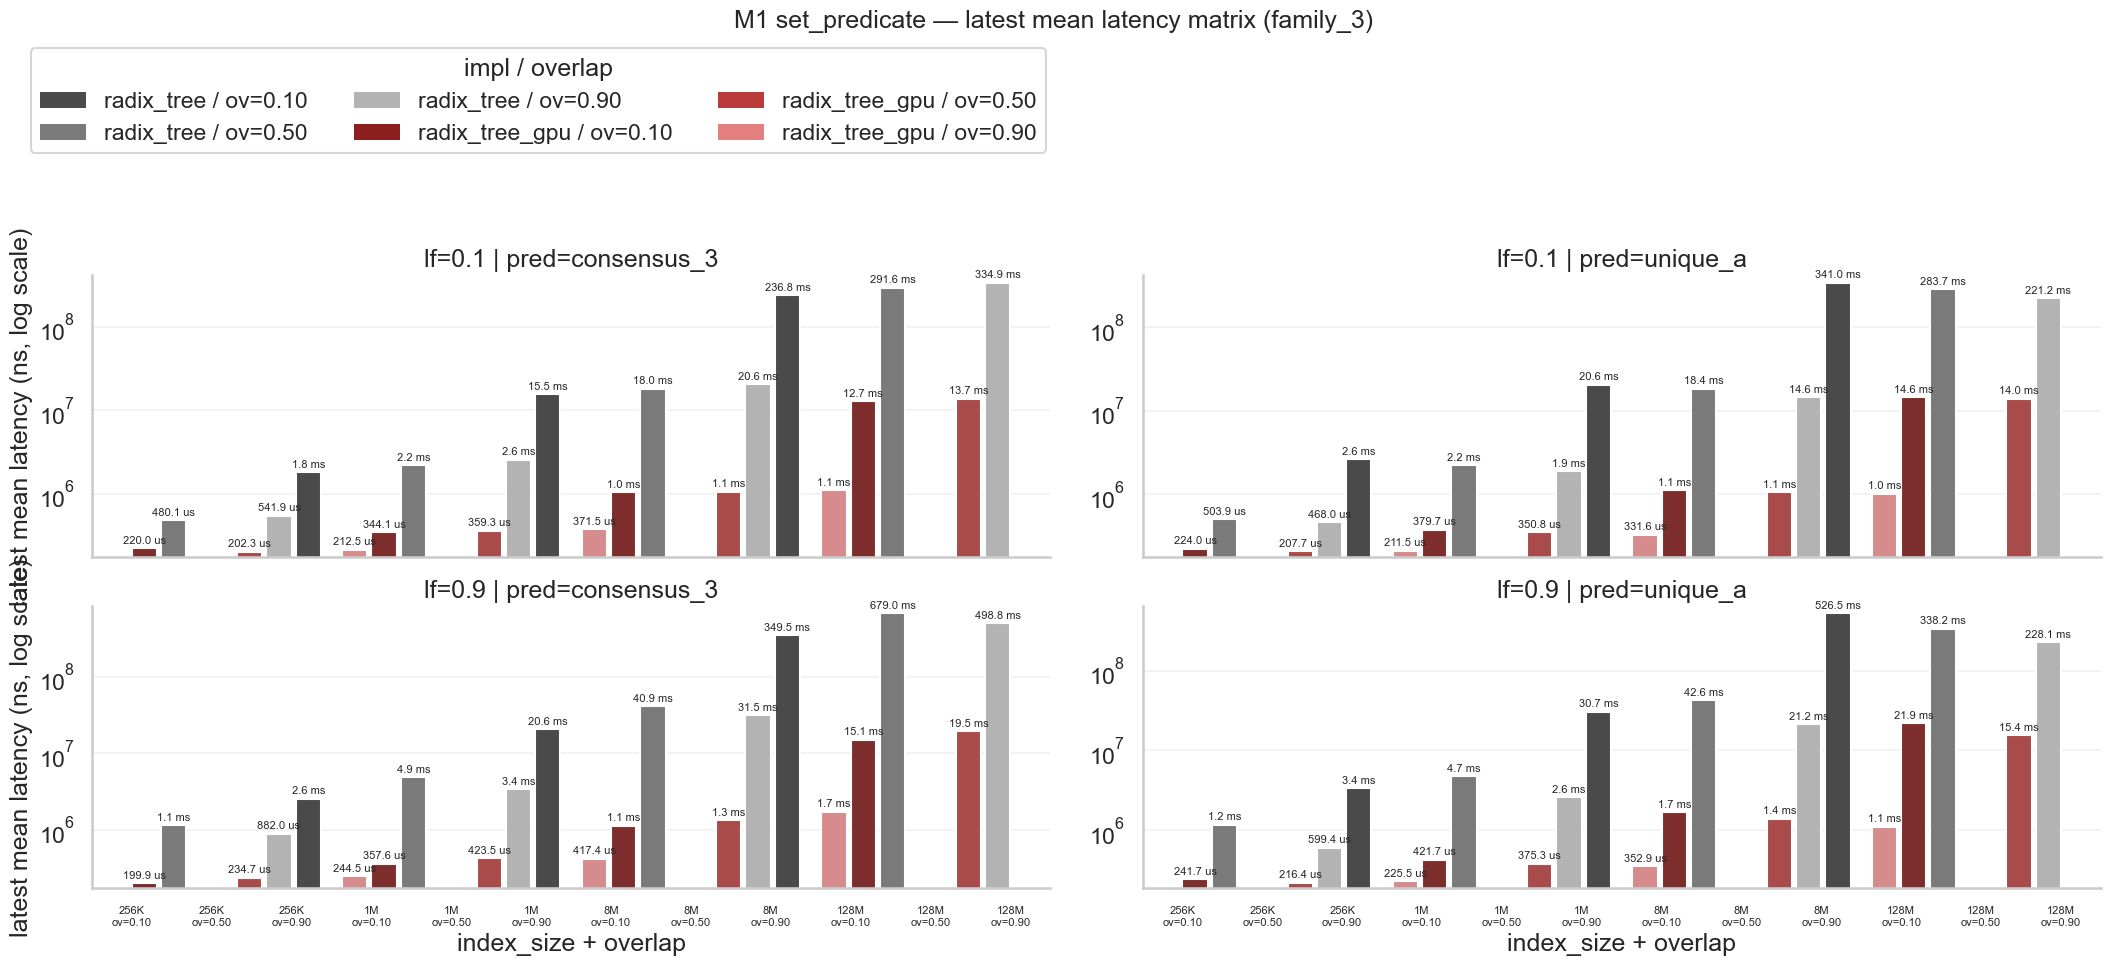

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

sns.set_theme(style="whitegrid", context="talk")

for family, fam_preds in [
    ("family_2", ["intersect_2", "diff_ab", "sym_diff"]),
    ("family_3", ["consensus_3", "unique_a"]),
]:
    fam = sp_latest[sp_latest["family"] == family].copy()
    fam["predicate"] = fam["predicate"].astype(str)
    fam = fam[fam["predicate"].isin(fam_preds)]
    if fam.empty:
        continue

    # Enforce family-local predicate facets only.
    fam["predicate"] = pd.Categorical(fam["predicate"], categories=fam_preds, ordered=True)

    fam["size_overlap"] = fam.apply(lambda r: f"{r['index_size']}\nov={float(r['overlap']):.2f}", axis=1)

    size_overlap_order = [f"{s}\nov={ov:.2f}" for s in size_order for ov in overlap_order]
    fam["size_overlap"] = pd.Categorical(fam["size_overlap"], categories=size_overlap_order, ordered=True)

    # Match non-log styling: grayscale shades for CPU overlaps, blue shades for GPU overlaps.
    fam["series"] = fam["impl"].astype(str) + " / ov=" + fam["overlap"].astype(float).map(lambda x: f"{x:.2f}")
    series_order = [
        f"{impl} / ov={ov:.2f}"
        for impl in ["radix_tree", "radix_tree_gpu"]
        for ov in overlap_order
    ]
    cpu_overlap_colors = {0.10: "#4a4a4a", 0.50: "#7a7a7a", 0.90: "#b3b3b3"}
    gpu_overlap_colors = {0.10: "#8c1f1f", 0.50: "#b93b3b", 0.90: "#e37f7f"}
    series_palette = {
        f"radix_tree / ov={ov:.2f}": cpu_overlap_colors[float(ov)]
        for ov in overlap_order
    }
    series_palette.update(
        {
            f"radix_tree_gpu / ov={ov:.2f}": gpu_overlap_colors[float(ov)]
            for ov in overlap_order
        }
    )

    g = sns.catplot(
        data=fam.sort_values(["occupancy", "predicate", "size_overlap", "impl"]),
        kind="bar",
        x="size_overlap",
        y="value",
        hue="series",
        hue_order=series_order,
        row="occupancy",
        col="predicate",
        row_order=occupancy_order,
        col_order=fam_preds,
        sharey=False,
        height=5.0,
        aspect=1.8,
        palette=series_palette,
        errorbar=None,
        width=1.9,
    )

    g.set_titles(row_template="lf={row_name}", col_template="pred={col_name}")
    g.set_axis_labels("index_size + overlap", "latest mean latency (ns, log scale)")

    for ax in g.axes.flat:
        for container in ax.containers:
            labels = [human_latency(v) if not pd.isna(v) else "" for v in container.datavalues]
            ax.bar_label(container, labels=labels, padding=2, fontsize=8)

        # Log y-scale keeps smaller index-size bars visible next to large values.
        positive_vals = [
            float(v)
            for c in ax.containers
            for v in c.datavalues
            if pd.notna(v) and float(v) > 0
        ]
        if positive_vals:
            ymin = max(min(positive_vals) * 0.85, 1e-3)
            ymax = max(positive_vals) * 1.25
            ax.set_yscale("log")
            ax.set_ylim(ymin, ymax)

        ax.tick_params(axis="x", labelrotation=0, labelsize=8)
        ax.grid(True, axis="y", alpha=0.25)

    # Match non-log layout: explicit top-left legend and extra headroom.
    if g._legend is not None:
        g._legend.remove()
    legend_handles = [Patch(facecolor=series_palette[s], edgecolor="none", label=s) for s in series_order]
    g.figure.legend(
        handles=legend_handles,
        labels=series_order,
        title="impl / overlap",
        loc="upper left",
        bbox_to_anchor=(0.015, 0.97),
        ncol=3,
        frameon=True,
        borderaxespad=0.6,
    )

    plt.suptitle(
        f"M1 set_predicate — latest mean latency matrix ({family})",
        y=0.995,
        fontsize=18,
    )
    g.figure.subplots_adjust(top=0.73, left=0.05, right=0.99)
    plt.show()

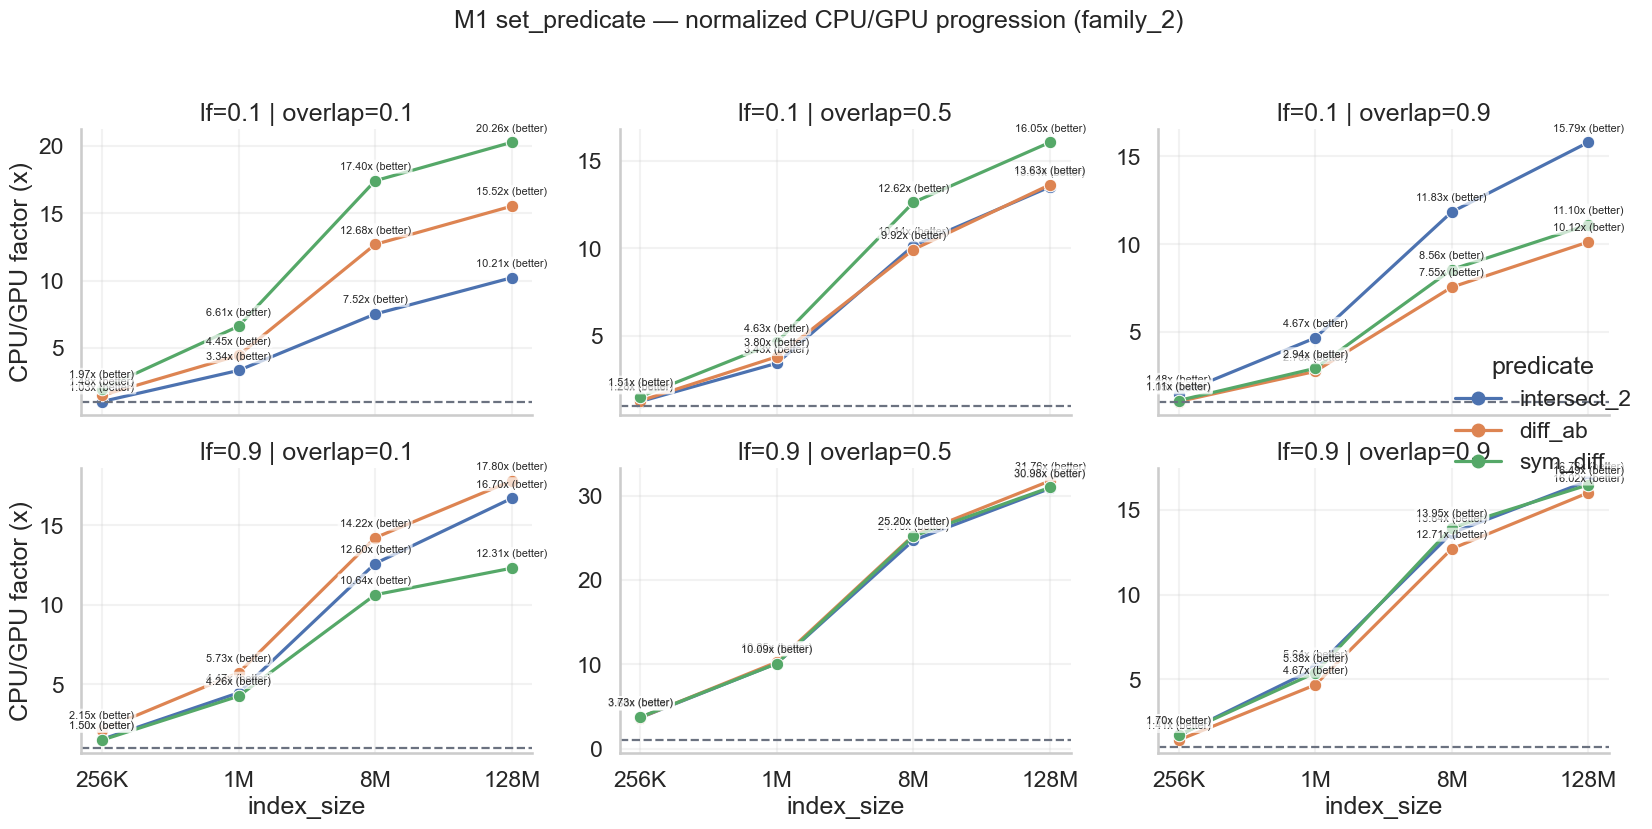

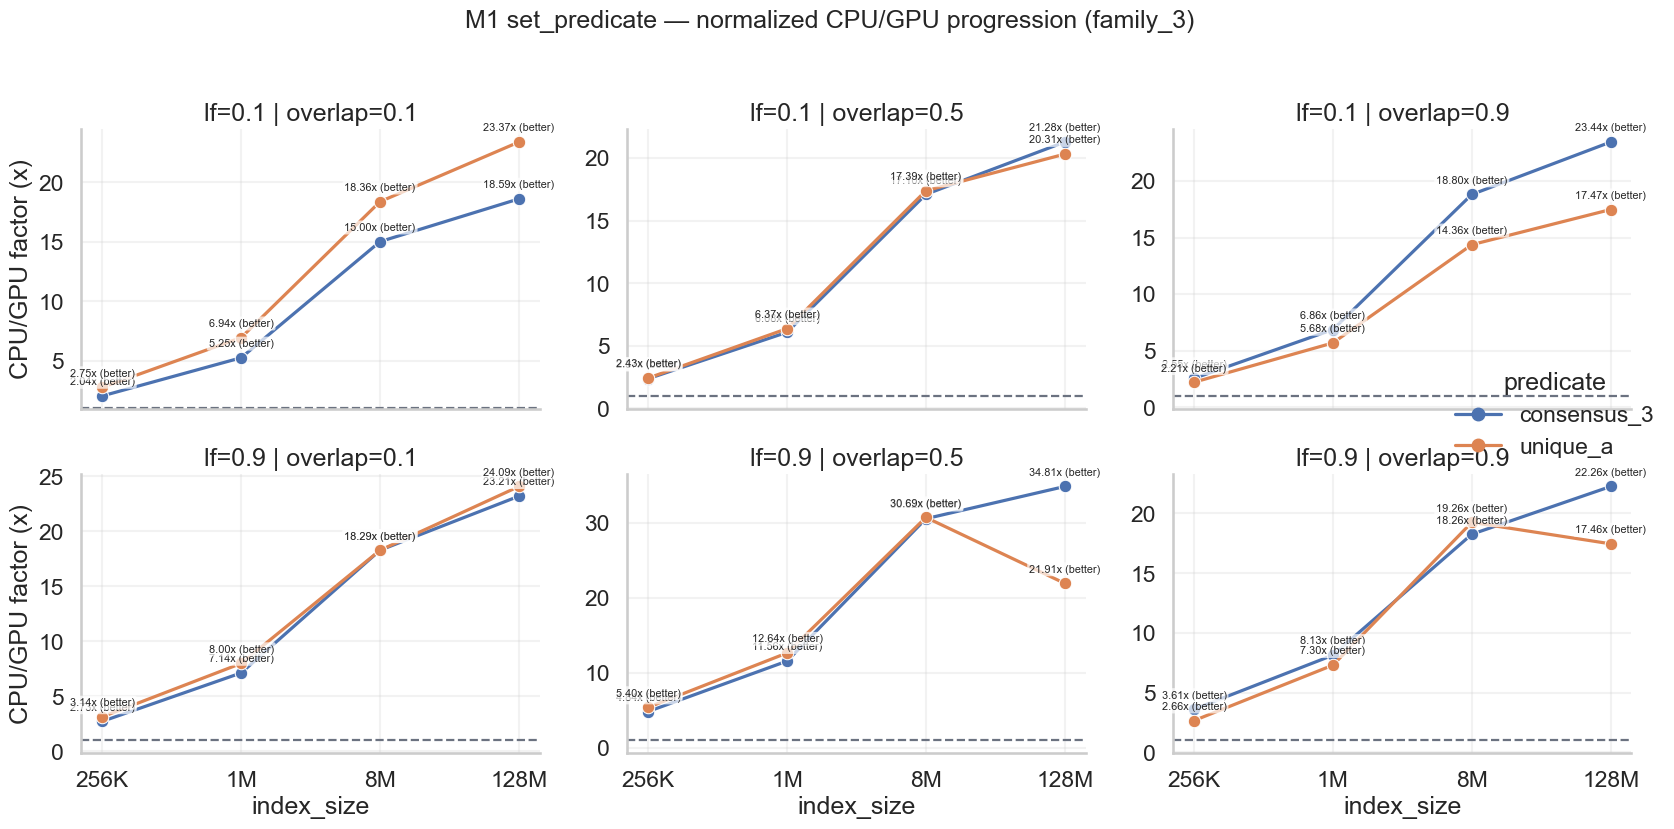

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

for family, fam_preds in [
    ("family_2", ["intersect_2", "diff_ab", "sym_diff"]),
    ("family_3", ["consensus_3", "unique_a"]),
]:
    fam = sp_latest[sp_latest["family"] == family].copy()
    fam["predicate"] = fam["predicate"].astype(str)
    fam = fam[fam["predicate"].isin(fam_preds)]
    if fam.empty:
        continue

    fam["predicate"] = pd.Categorical(fam["predicate"], categories=fam_preds, ordered=True)

    pvt = (
        fam.pivot_table(
            index=["index_size", "occupancy", "overlap", "predicate"],
            columns="impl",
            values="value",
            aggfunc="first",
        )
        .reset_index()
    )

    pvt = pvt.dropna(subset=["radix_tree", "radix_tree_gpu"]).copy()
    pvt["speedup_factor"] = pvt["radix_tree"] / pvt["radix_tree_gpu"]

    pvt["index_size"] = pd.Categorical(pvt["index_size"], categories=size_order, ordered=True)
    pvt["occupancy"] = pd.Categorical(pvt["occupancy"], categories=occupancy_order, ordered=True)
    pvt["overlap"] = pd.Categorical(pvt["overlap"], categories=overlap_order, ordered=True)

    g = sns.relplot(
        data=pvt.sort_values(["occupancy", "overlap", "predicate", "index_size"]),
        kind="line",
        x="index_size",
        y="speedup_factor",
        hue="predicate",
        hue_order=fam_preds,
        row="occupancy",
        row_order=occupancy_order,
        col="overlap",
        col_order=overlap_order,
        marker="o",
        linewidth=2.3,
        height=4.1,
        aspect=1.2,
        facet_kws={"sharey": False},
    )

    for ax in g.axes.flat:
        ax.axhline(1.0, linestyle="--", linewidth=1.6, color="#6b7280")
        ax.grid(True, alpha=0.25)

    # point labels: x.xx (better/worse)
    for (occ, ov), sub in pvt.groupby(["occupancy", "overlap"]):
        try:
            ax = g.axes_dict[(occ, ov)]
        except Exception:
            continue
        for _, row in sub.iterrows():
            f = float(row["speedup_factor"])
            label = f"{f:.2f}x ({'better' if f >= 1.0 else 'worse'})"
            yoff = 8 if f >= 1.0 else -14
            ax.annotate(
                label,
                xy=(row["index_size"], f),
                xytext=(0, yoff),
                textcoords="offset points",
                ha="center",
                fontsize=7.8,
                bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.7),
            )

    g.set_titles(row_template="lf={row_name}", col_template="overlap={col_name}")
    g.set_axis_labels("index_size", "CPU/GPU factor (x)")
    g._legend.set_title("predicate")

    plt.suptitle(f"M1 set_predicate — normalized CPU/GPU progression ({family})", y=1.02, fontsize=18)
    plt.tight_layout()
    plt.show()